Odpowiedź ma być skrypt pythona i odpalamy go z terminala za pomocą np. argparse

python classify.py test.csv

Na wejściu jest plik test.csv, tam mamy dopisać kolumnę nową z nazwą "RESULT" i nadpisać plik csv

* team: T – terrorists, CT – counter-terrorists;
* (detonation raw x, detonation raw y , detonation raw z ): grenade detonation raw coordinates;
* (throw from raw x, throw from raw y, throw from raw z ): raw coordinates of the player when the grenade is being thrown;
* throw tick : the exact tick (unit of game time, 128 ticks per second, counted from the beginning of the game), when the grenade is being thrown;
* detonation tick : the exact tick, when the grenade is being detonated;
* TYPE : type of the grenade (smoke, flashbang, molotov );
* map name: map on which the match was played (de inferno, de mirage);

In [104]:
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#PCA
from sklearn.decomposition import PCA

#Machine Learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from copy import deepcopy

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from tabulate import tabulate

import joblib

In [105]:
train = pd.read_csv('./data/train.csv')

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        543 non-null    int64  
 1   demo_id           543 non-null    int64  
 2   demo_round_id     543 non-null    int64  
 3   round_start_tick  543 non-null    int64  
 4   weapon_fire_id    543 non-null    int64  
 5   team              543 non-null    object 
 6   detonation_raw_x  543 non-null    float64
 7   detonation_raw_y  543 non-null    float64
 8   detonation_raw_z  543 non-null    float64
 9   throw_from_raw_x  543 non-null    float64
 10  throw_from_raw_y  543 non-null    float64
 11  throw_from_raw_z  543 non-null    float64
 12  throw_tick        543 non-null    int64  
 13  detonation_tick   543 non-null    float64
 14  TYPE              543 non-null    object 
 15  map_name          543 non-null    object 
 16  LABEL             543 non-null    bool   
dt

In [14]:
train.isna().sum()

Unnamed: 0          0
demo_id             0
demo_round_id       0
round_start_tick    0
weapon_fire_id      0
team                0
detonation_raw_x    0
detonation_raw_y    0
detonation_raw_z    0
throw_from_raw_x    0
throw_from_raw_y    0
throw_from_raw_z    0
throw_tick          0
detonation_tick     0
TYPE                0
map_name            0
LABEL               0
dtype: int64

# Visualization

## First I want to plot points on the map image

### Functions to scale coords to 1200 resolution

In [193]:
def scale_point_x(x,startX,endX,res_X=1024):
    sizeX=endX-startX
    if startX < 0:
        x += startX *(-1.0)
    else:
        x += startX
    x_out = float((x / abs(sizeX)) * res_X)
    return x_out

def scale_point_y(y,startY,endY,res_Y=1024):
    sizeY=endY-startY
    if startY < 0:
        y += startY *(-1.0)
    else:
        y += startY
    y_out = float((y / abs(sizeY)) * res_Y)
    return res_Y-y_out

Those numbers srartX,startY, etc. and maps images I have taken from kaggle, link below.


https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage


In [194]:
mirage = train[(train['map_name'] == 'de_mirage')]

In [195]:
#funtion to scale x and y coords to fit on map image. 
def add_attributes(df,startX,endX,startY,endY):
    df['detonation_x'] = df['detonation_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['detonation_y'] = df['detonation_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    df['throw_x'] = df['throw_from_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['throw_y'] = df['throw_from_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    return df

In [196]:
mirage = add_attributes(mirage,-3217,1912,-3401,1682)

In [199]:
#Function to plot place from where grenade has been thrown and place where it landed. 
# as the input it takes dataframe only with samples to specific map and map name
def nades_on_map(df,map):
    map_name = 'maps/' + map + '.png'
    im = plt.imread(map_name)
    plt.figure(figsize=(22,11))
    plt.subplot(1,2,1)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == True]['detonation_x'], y = df[df['LABEL'] == True]['detonation_y'], hue = df[df['LABEL'] == True]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == True]['throw_x'],y = df[df['LABEL'] == True]['throw_y'], hue = df[df['LABEL'] == True]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Correct throw')


    plt.subplot(1,2,2)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == False]['detonation_x'], y = df[df['LABEL'] == False]['detonation_y'], hue = df[df['LABEL'] == False]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == False]['throw_x'],y = df[df['LABEL'] == False]['throw_y'], hue = df[df['LABEL'] == False]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Incorrect throw')


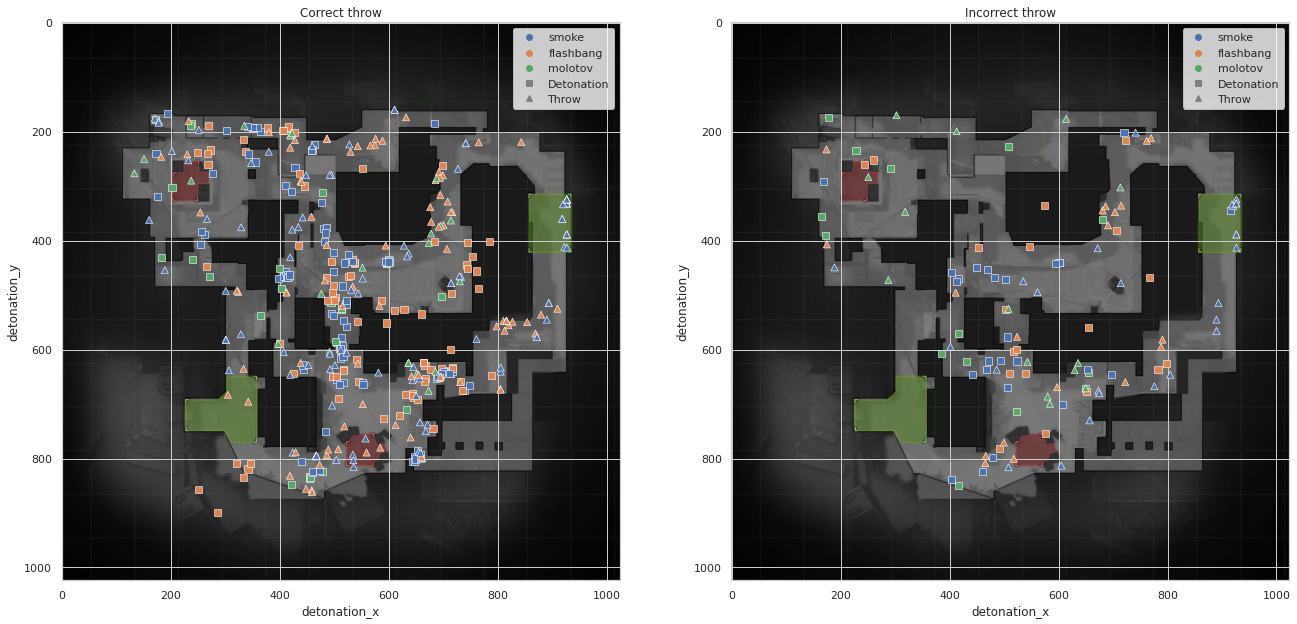

In [200]:
nades_on_map(mirage,'de_mirage')
plt.savefig('./plots/granades_on_mirage.png')
plt.show()

In [22]:
#same thing for inferno map 
inferno = train[(train['map_name'] == 'de_inferno')]

In [23]:
inferno = add_attributes(inferno,-1960,2797,-1062,3800)

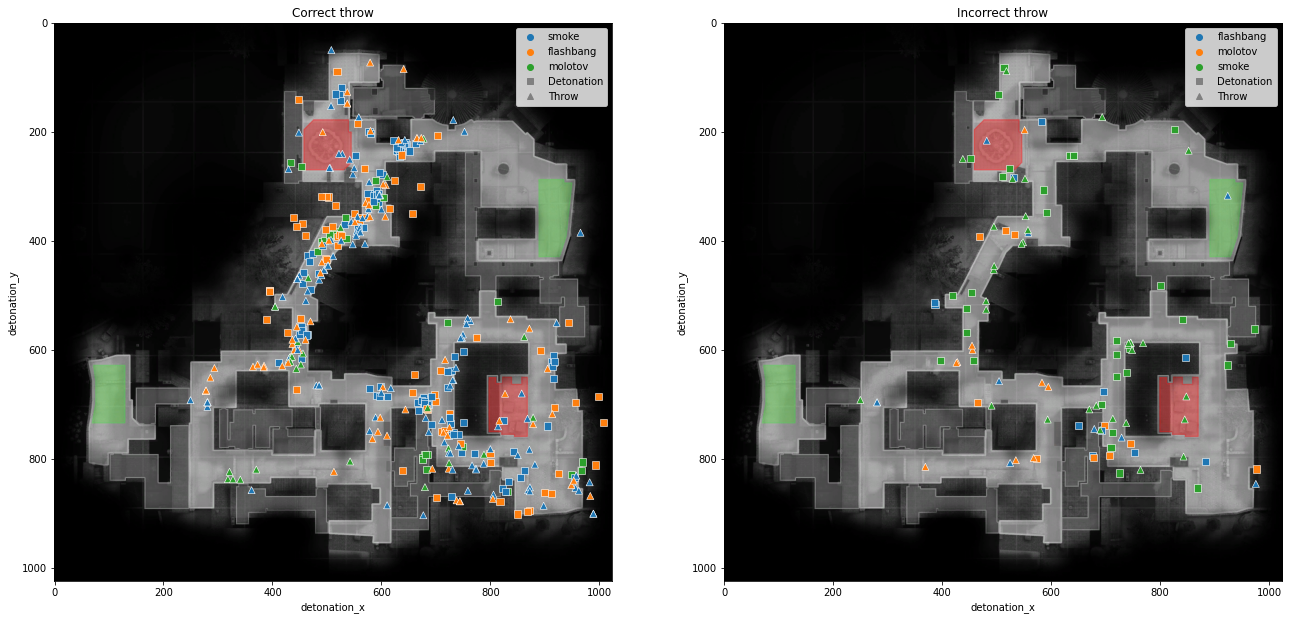

In [24]:
nades_on_map(inferno,'de_inferno')
#plt.savefig('./plots/granades_on_inferno.png')
plt.show()

In [100]:
#funtion to plot the same thing as the previuos, but this time I plot only one given sample.
def draw_nade(row):
    #save informations about the grenade to plot 
    map = row['map_name']
    label = row['LABEL']
    nade_type = row['TYPE'] 
    
    if map == 'de_inferno':
        map_name = 'maps/' + map + '.png'
        startX,endX,startY,endY = -1960,2797,-1062,3800

    elif map == 'de_mirage':
        map_name = 'maps/' + map + '.png'
        startX,endX,startY,endY = -3217,1912,-3401,1682

    else :
        print('Map incorrect')
    
    detonation_x = scale_point_x(row['detonation_raw_x'],startX = startX, endX = endX)
    detonation_y = scale_point_y(row['detonation_raw_y'],startY=startY, endY=endY)
    throw_x = scale_point_x(row['throw_from_raw_x'],startX=startX, endX=endX)
    throw_y = scale_point_y(row['throw_from_raw_y'],startY=startY, endY=endY)

    plt.figure(figsize=(11,11))
    im = plt.imread(map_name)
    t = plt.imshow(im)
    sns.scatterplot(x = [detonation_x], y = [detonation_y], color = 'blue', marker = "s", s = 50)
    ax = sns.scatterplot(x = [throw_x],y = [throw_y], color = 'orange', marker="^" , s = 50)
    detonation_patch = mlines.Line2D([], [], color = 'blue', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'orange', marker='^', linestyle='None')
    handles = [detonation_patch,throw_patch]
    labels = ['Detonation','Throw']
    #add those information on plot
    ax.text(50, 100, 'Map:{},\nGranade:{},\nThrown correctly:{}'.format(map,nade_type,label),
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    plt.legend(handles, labels)
    plt.show()


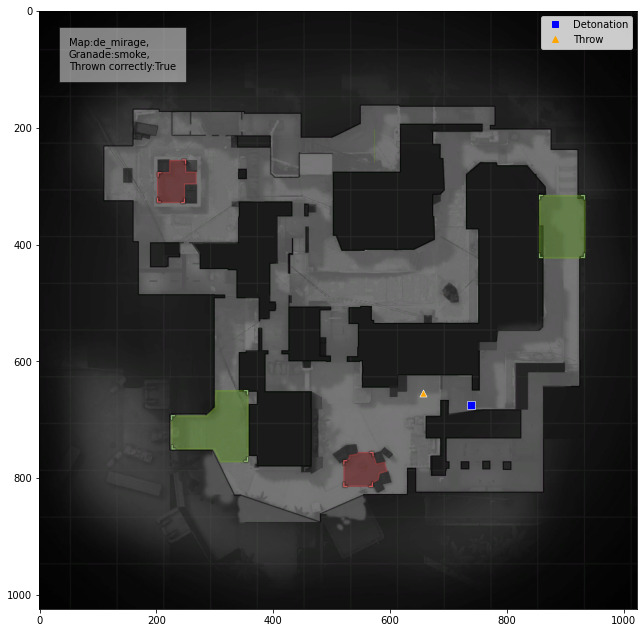

In [28]:
draw_nade(train.iloc[2])

## More visualization

In [101]:
#function to create a nice countplot 
def plot_count(feature, data):
    plt.figure(figsize = (7,7))
    ax = sns.countplot(x = feature, data = data,  palette='colorblind')
    height = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
            ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+5),animated=True)
    plot_name = 'plots/{}_plot.png'.format(feature)
    plt.savefig(plot_name)
    plt.show()

In [102]:
#fucntion to create a nice countplot and separate it by one given variable
def plot_count_vs_variable(feature, data, vs):
    plt.figure(figsize = (7,7))
    ax = sns.countplot(x = feature, data = data, hue = vs, palette='colorblind')
    height = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
            ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+5),animated=True)
    plot_name = 'plots/{}_plot.png'.format(feature)
    plt.savefig(plot_name)
    plt.show()

### Label count

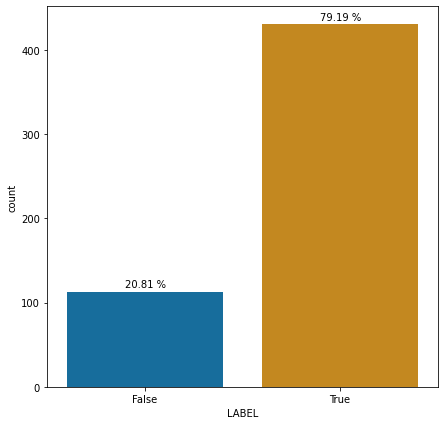

In [181]:
plot_count('LABEL',train)

### Map type

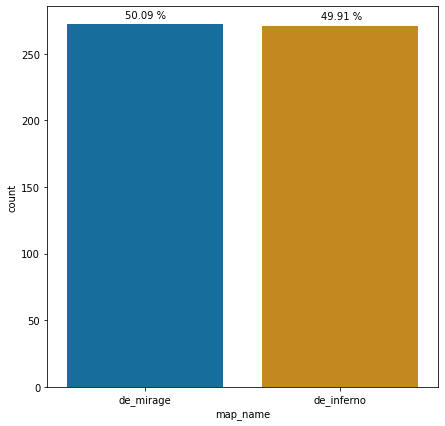

In [182]:
plot_count('map_name', train)

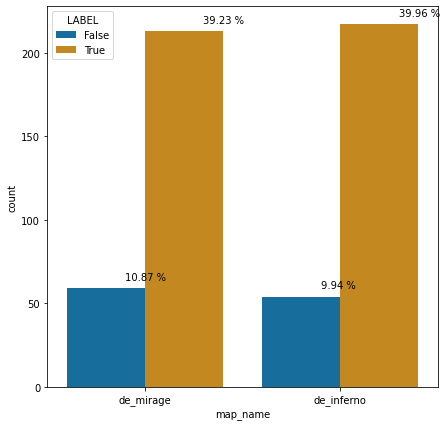

In [184]:
plot_count_vs_variable('map_name', train, vs = 'LABEL')

### Team

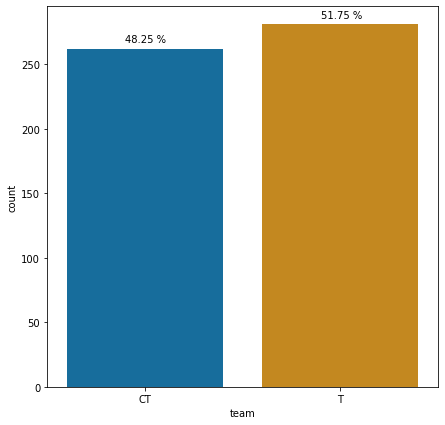

In [185]:
plot_count('team' ,train)

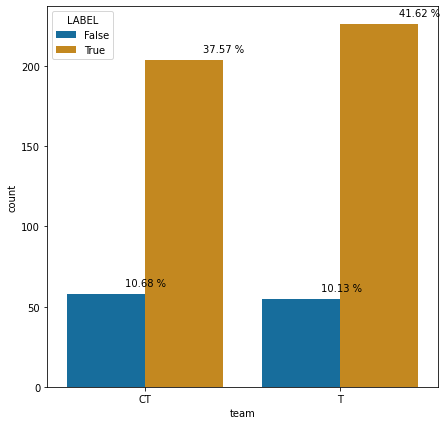

In [186]:
plot_count_vs_variable('team',train,'LABEL')

### Grenade type

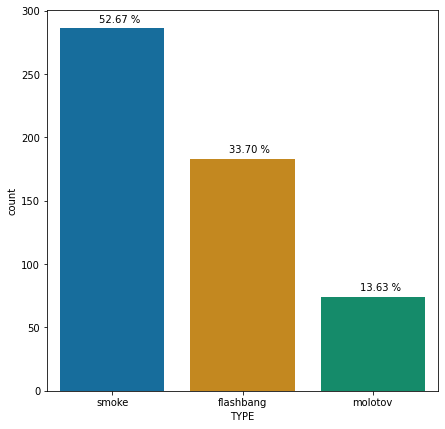

In [187]:
plot_count('TYPE' ,train)

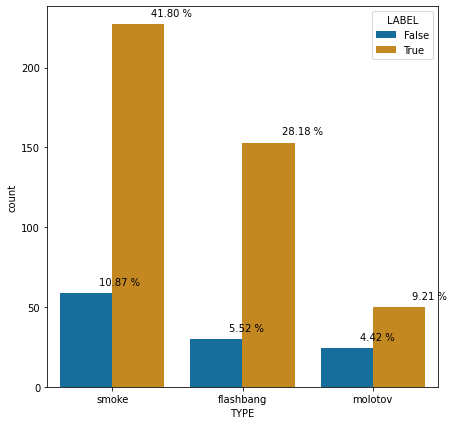

In [188]:
plot_count_vs_variable('TYPE',train,'LABEL')

### distribution of x,y,z coords 

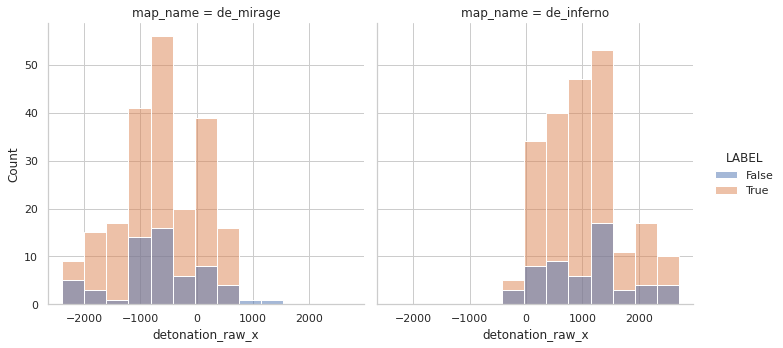

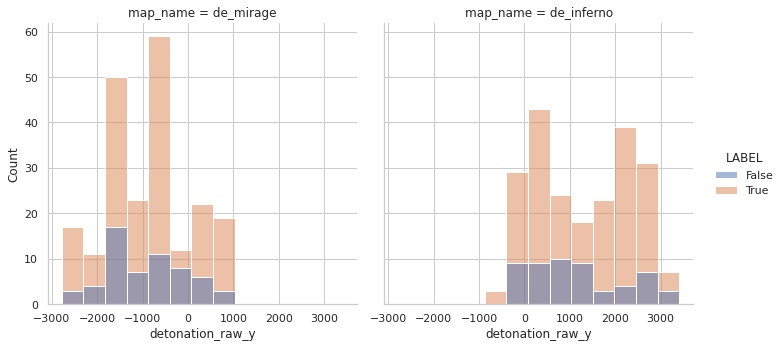

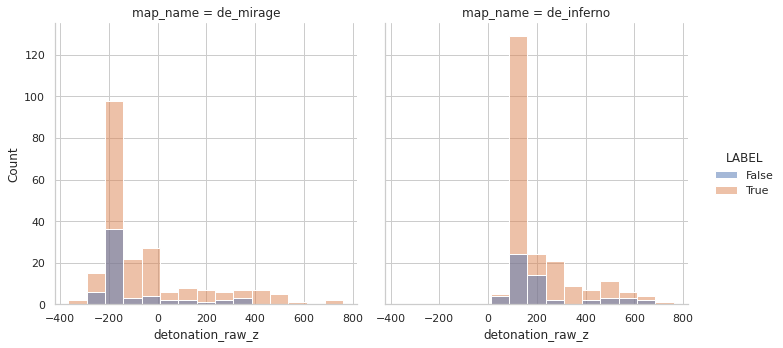

In [192]:
sns.displot(data = train, x = 'detonation_raw_x', hue = 'LABEL', col = 'map_name')
plt.savefig('./plots/dist_x.png')
sns.displot(data = train, x = 'detonation_raw_y', hue = 'LABEL', col = 'map_name')
plt.savefig('./plots/dist_y.png')
sns.displot(data = train, x = 'detonation_raw_z', hue = 'LABEL', col = 'map_name')
plt.savefig('./plots/dist_z.png')




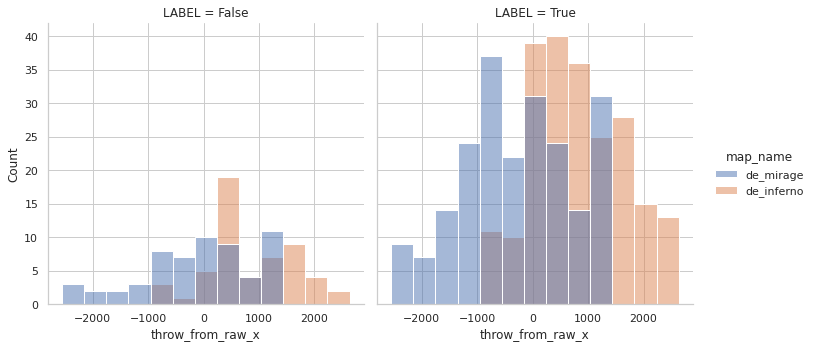

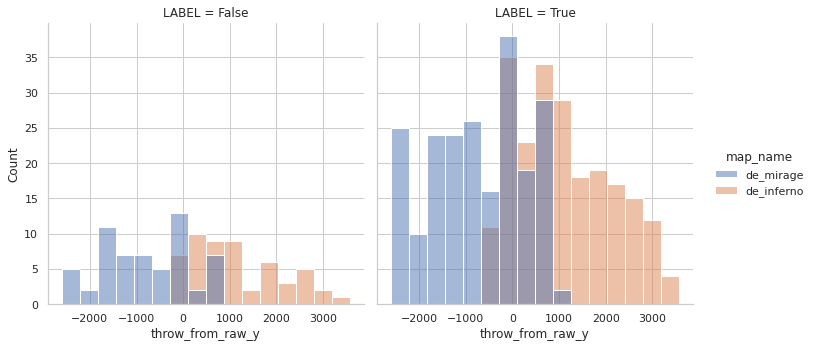

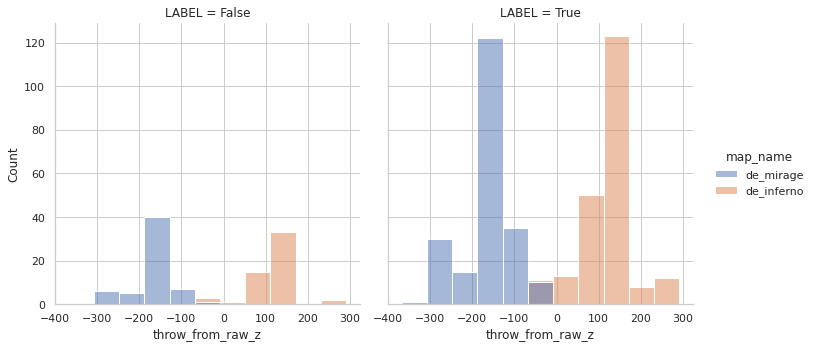

In [201]:
sns.displot(data = train, x = 'throw_from_raw_x', hue = 'map_name', col = 'LABEL')
sns.displot(data = train, x = 'throw_from_raw_y', hue = 'map_name', col = 'LABEL')
sns.displot(data = train, x = 'throw_from_raw_z', hue = 'map_name', col = 'LABEL')

### Corrplot 

<AxesSubplot:>

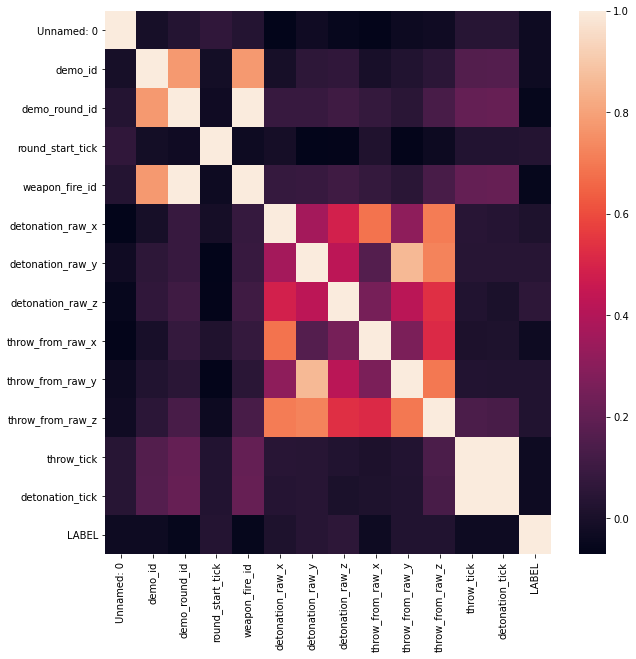

In [4]:
plt.figure(figsize = (10,10))
num_cols = train.select_dtypes(exclude=['object']).columns
corr = train[num_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Feature Engineering 

In [174]:
# I create a copy of my dataset to work on it 
train_copy = deepcopy(train)


In [175]:
#Change columns witch time measured in "tick" to time in seconds and substract break between rounds
#whem time of round is higher than 130 seconds which is 1m 55s (csgo round time) then team took 60sec break (that's what esportsLAB says)
train_copy['throw_tick'] = train_copy['throw_tick'].apply(lambda x: (x/128) - 80 if x >= 130 else (x/128) - 20)
train_copy['detonation_tick'] = train_copy['detonation_tick'].apply(lambda x: (x/128) - 80 if x >= 130 else (x/128) - 20)

In [176]:
#Add a grenade duration time 
train_copy['nade_duration(s)'] = (train_copy['detonation_tick'] - train_copy['throw_tick'])/128

In [177]:
#remove useless columns
train_copy = train_copy.drop(['demo_id','demo_round_id','Unnamed: 0','round_start_tick','weapon_fire_id'], axis = 1)

In [178]:
X = train_copy.loc[:, train_copy.columns != 'LABEL']
y = train_copy['LABEL']

In [179]:
#one hot encoding
e = pd.get_dummies(X[['team','map_name','TYPE']])
X = X.join(e)

In [180]:
X = X.drop(['team','TYPE','map_name'], axis = 1)


### Feature importance

In [181]:
tree = ExtraTreesClassifier(random_state= 42)

In [182]:
tree.fit(X,y)



ExtraTreesClassifier(random_state=42)

In [117]:
for name, score in zip(list(X.columns), tree.feature_importances_):
    print(name,score)

detonation_raw_x 0.10895038939481655
detonation_raw_y 0.11973406076340788
detonation_raw_z 0.12167687333176995
throw_from_raw_x 0.09605603172183041
throw_from_raw_y 0.09785163563245637
throw_from_raw_z 0.08866751978609441
throw_tick 0.09970811486305778
detonation_tick 0.09030000719651848
nade_duration(s) 0.0916846920137942
team_CT 0.017356512353670722
team_T 0.01781581178892809
map_name_de_inferno 0.007851803749585846
map_name_de_mirage 0.005746850576417014
TYPE_flashbang 0.01124034511695711
TYPE_molotov 0.014354782532057164
TYPE_smoke 0.011004569178638004


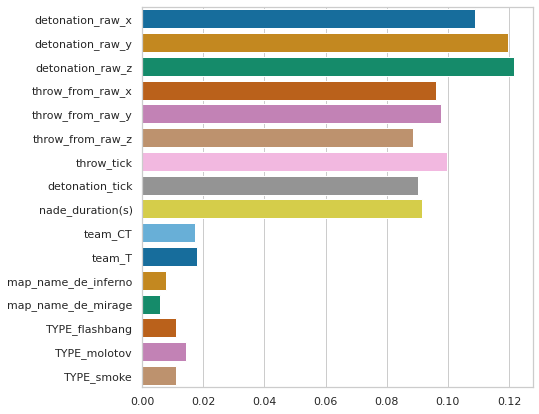

In [138]:

plt.figure(figsize=(7,7))
ax = sns.barplot(x=tree.feature_importances_, y=list(X.columns), orient = 'h', palette = 'colorblind')
plt.savefig('./plots/feature_importances.png')
plt.show()

## PCA

In [140]:

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [141]:
1 - pca.explained_variance_ratio_.sum()

0.10582492712570812

In [142]:
X2D = pd.DataFrame(X2D, columns=['V1','V2'])
X2D = X2D.join(y)

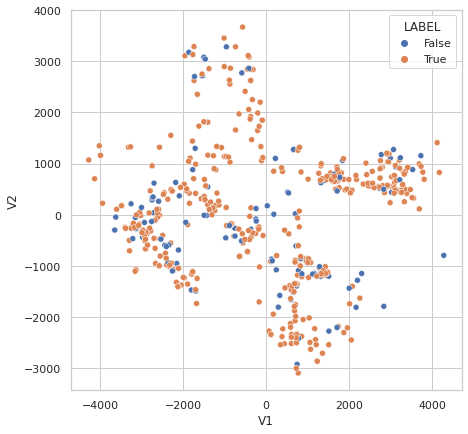

In [143]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'V1', y = 'V2', hue = 'LABEL', data = X2D)
plt.savefig('./plots/pca_first.png')

### Check if models give me good roc_auc score

In [183]:
tree_roc = cross_val_score(tree,X,y,cv=4,scoring='roc_auc')
print(tree_roc.mean())

0.5359219647056015


In [184]:
rf = RandomForestClassifier(class_weight = {1:1,0:2}, n_estimators = 200,  random_state = 42)

In [185]:
rf.fit(X,y)
rf_roc = cross_val_score(rf,X,y,cv=4,scoring='roc_auc')
print(rf_roc.mean())

0.5776677065802509


In [186]:
k = KNeighborsClassifier()
k.fit(X,y)
k_roc = cross_val_score(k,X,y,cv=4,scoring='roc_auc')
print(k_roc.mean())

0.5860580310784749


The roc_auc score is not so good, I will try decrease number of features to 5. Why I did it is explained in the pdf with solution explanation

In [151]:
train_copy = deepcopy(train)
train_copy = train_copy.drop(['demo_id','demo_round_id','Unnamed: 0','round_start_tick','weapon_fire_id', 'detonation_tick', 'throw_tick','throw_from_raw_x','throw_from_raw_y','throw_from_raw_z'], axis = 1)
X = train_copy.loc[:, train_copy.columns != 'LABEL']
y = train_copy['LABEL']
e = pd.get_dummies(X[['team','map_name','TYPE']])
X = X.join(e)
X = X.drop(['team','TYPE','map_name'], axis = 1)

In [152]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [153]:
1 - pca.explained_variance_ratio_.sum()

0.009755582197703339

In [154]:
X2D = pd.DataFrame(X2D, columns=['V1','V2'])
X2D = X2D.join(y)

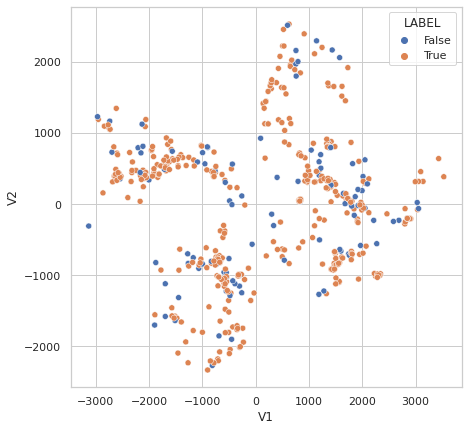

In [155]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'V1', y = 'V2', hue = 'LABEL', data = X2D)
plt.savefig('./plots/pca_second.png')

I think now points can be little easier to classify 

In [156]:
tree = ExtraTreesClassifier(random_state= 42)
tree.fit(X,y)
tree_roc_2 = cross_val_score(tree,X,y,cv=4,scoring='roc_auc')
print(tree_roc_2.mean())

0.5753736729858627


In [157]:
rf = RandomForestClassifier(class_weight = {1:1,0:2}, n_estimators = 200,  random_state = 42)
rf.fit(X,y)
rf_roc_2 = cross_val_score(rf,X,y,cv=4,scoring='roc_auc')
print(rf_roc_2.mean())

0.6150970557593181


In [158]:
k = KNeighborsClassifier()
k.fit(X,y)
k_roc_2 = cross_val_score(k,X,y,cv=4,scoring='roc_auc')
print(k_roc_2.mean())

0.6208020869034404


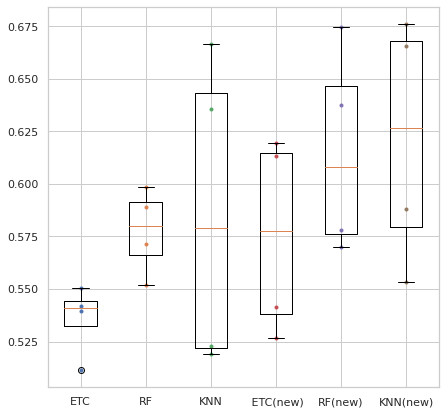

In [188]:
plt.figure(figsize=(7,7))
plt.plot([1]*4, tree_roc, ".")
plt.plot([2]*4, rf_roc, ".")
plt.plot([3]*4, k_roc, ".")
plt.plot([4]*4, tree_roc_2, ".")
plt.plot([5]*4, rf_roc_2, ".")
plt.plot([6]*4, k_roc_2, ".")
plt.boxplot([tree_roc,rf_roc,k_roc, tree_roc_2, rf_roc_2, k_roc_2], labels=("ETC","RF", 'KNN',' ETC(new)','RF(new)','KNN(new)'))
plt.savefig('./plots/roc_auc_feature_selection.png')
plt.show()

# Prepare dataset to machine learning models 

Function to drop columns

In [217]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [218]:
#numeric columns
num_cols = [
 'detonation_raw_x',
 'detonation_raw_y',
 'detonation_raw_z']
#categorical columns
cat_cols = ['TYPE','map_name']

In [219]:
#pipeline to transform numerical columns
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(num_cols)),
        ("scale", StandardScaler())
    ])

In [220]:
#pipeline to transform categorical columns
cat_pipeline = Pipeline([
    ("select cat", DataFrameSelector(cat_cols)),
    ("One hot encoder", OneHotEncoder(sparse=False))
])

In [221]:
#combine pipelines
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [222]:
#transform train dataset
X = preprocess_pipeline.fit_transform(train)

In [223]:
#select labels to train dataset
y = train['LABEL']

## Only weights

In [17]:
model_params = {
    'SGD': {
        'model': SGDClassifier(n_jobs=-1, random_state = 42),
        'params': {
            'penalty': ['l1','l2'],
            'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
            'class_weight' : [{1:1,0:4},{1:1,0:3},{1:1,0:2}]
        }
    },
    'svm2': {
        'model': SVC(kernel='poly',random_state = 42),
        'params' : {
            'C': [1,10,50,100],
            'degree': [2,3,4,5],
            'probability': [True],
            'class_weight': [{1:1,0:4},{1:1,0:3},{1:1,0:2}]
        }  
    },
    'svm': {
        'model': SVC(kernel='rbf',random_state = 42),
        'params' : {
            'C': [1,10,20,50,100,150,200],
            'probability': [True],
            'class_weight': [{1:1,0:4},{1:1,0:3},{1:1,0:2}],
            'gamma':[0.1,0.5,1,2,'auto','scale']
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state = 42),
        'params' : {
            'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth': [3,4,5,10,30,None],
            'class_weight' : [{1:1,0:4},{1:1,0:3},{1:1,0:2}]
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(n_jobs=-1,random_state = 42),
        'params' : {
            'n_estimators': [50,100,200,500],
            'criterion' : ['gini', 'entropy'],
            'max_depth': [3,4,5,10,30,None],
            'class_weight' : [{1:1,0:4},{1:1,0:3},{1:1,0:2}]
        }
    },
    'KNN':{
        'model': KNeighborsClassifier(n_jobs=-1),
        'params' : {
            'p': [1,2],
            'weights': ['uniform', 'distance'],
            'n_neighbors': [1,2,3]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(n_jobs=-1, random_state = 42),
        'params': {
            'C': [1,10,50,100],
            'solver' : ['lbfgs', 'liblinear','saga'],
            'penalty' : ['l1','l2'],
            'class_weight' : [{1:1,0:4},{1:1,0:3},{1:1,0:2}]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(random_state = 42),
        'params': {
            'max_depth': [6,10],
            'learning_rate':[0.01,0.10,0.20,0.30],

        }
    }
}

In [18]:
#number of folds to cross validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

In [19]:
#with Grid search find best model
scores = []
i = 1
for model_name, mp in model_params.items():
    print('Processing... ',i,'/',len(model_params))
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, scoring='roc_auc', return_train_score=False, n_jobs = -1)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    i+=1
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])


Processing...  1 / 8
Processing...  2 / 8
Processing...  3 / 8
Processing...  4 / 8
Processing...  5 / 8
Processing...  6 / 8
Processing...  7 / 8
Processing...  8 / 8
[02:15:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
#best models 
df

model  best_score  \
0                  SGD    0.572451   
1                 svm2    0.643522   
2                  svm    0.666869   
3        decision_tree    0.609803   
4        random_forest    0.675864   
5                  KNN    0.667849   
6  logistic_regression    0.533886   
7              xgboost    0.641892   

                                         best_params  
0  {'class_weight': {1: 1, 0: 3}, 'loss': 'modifi...  
1  {'C': 100, 'class_weight': {1: 1, 0: 2}, 'degr...  
2  {'C': 20, 'class_weight': {1: 1, 0: 2}, 'gamma...  
3  {'class_weight': {1: 1, 0: 3}, 'criterion': 'e...  
4  {'class_weight': {1: 1, 0: 3}, 'criterion': 'e...  
5  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}  
6  {'C': 1, 'class_weight': {1: 1, 0: 2}, 'penalt...  
7            {'learning_rate': 0.2, 'max_depth': 10}

In [19]:
#param grid for ExtraTrees Classifier
tree_param ={
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [50,100,150],
    'max_depth': [3,4,5,6,7,10, None],
    'class_weight' : [{1:1,0:2},{1:1,0:3},{1:1,0:2.5}],
    'min_samples_split': [2,3,4]

}

#find best params with gridsearch 
tree_best = GridSearchCV(ExtraTreesClassifier(random_state = 42, n_jobs = -1), cv = cv, param_grid=tree_param,   scoring='roc_auc', return_train_score=False, n_jobs=-1)
tree_best.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=1),
             estimator=ExtraTreesClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 2, 1: 1}, {0: 3, 1: 1},
                                          {0: 2.5, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 10, None],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc')

In [20]:
tree_best.best_score_

0.7040749371163821

In [210]:
tree_best.best_params_

{'class_weight': {1: 1, 0: 3},
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 50}

Fit best models to data and evaluate it 

In [224]:
tree = tree_best.best_estimator_
tree.fit(X,y)

ExtraTreesClassifier(class_weight={0: 3, 1: 1}, n_estimators=50, n_jobs=-1,
                     random_state=42)

In [213]:
KNN = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2)
KNN.fit(X,y)

dt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 10, random_state=42)
dt.fit(X,y)

rf = RandomForestClassifier(class_weight={1:1,0:3},criterion = 'entropy', max_depth = 30, n_estimators = 500, random_state=42)
rf.fit(X,y)

svm = SVC(kernel='rbf', C = 20, class_weight={1:1,0:2}, gamma = 2, probability= True, random_state=42)
svm.fit(X,y)

[22:47:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SVC(C=20, class_weight={0: 2, 1: 1}, gamma=2, probability=True, random_state=42)

Evaluation with roc_auc score

In [226]:
knn_roc = cross_val_score(KNN,X,y,cv=cv,scoring='roc_auc')
dt_roc = cross_val_score(dt,X,y,cv=cv,scoring='roc_auc')
rf_roc = cross_val_score(rf,X,y,cv=cv,scoring='roc_auc')
svm_roc = cross_val_score(svm,X,y,cv=cv,scoring='roc_auc')
tree_best_roc = cross_val_score(tree,X,y,cv=cv,scoring='roc_auc')

[22:48:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

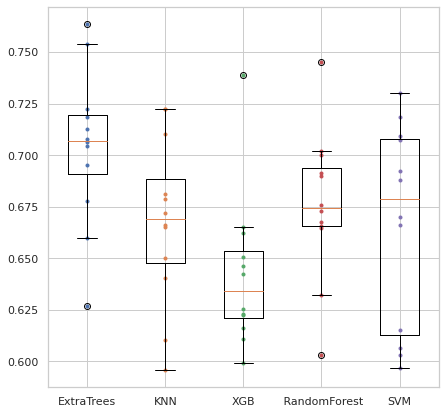

In [227]:
plt.figure(figsize=(7,7))
plt.plot([1]*12, tree_best_roc, ".")
plt.plot([2]*12, knn_roc, ".")
plt.plot([3]*12, dt_roc, ".")
plt.plot([4]*12, rf_roc, ".")
plt.plot([5]*12, svm_roc, ".")
plt.boxplot([tree_best_roc,knn_roc,dt_roc, rf_roc, svm_roc], labels=("ExtraTrees","KNN", 'XGB',' RandomForest','SVM'))
plt.savefig('./plots/roc_auc_weights.png')
plt.show()

Class to do more evaluation, it is sometimes not correct to use cross_val_predict with evaluation technics and I have to change it later

In [142]:
class BinaryMetrics():
    def __init__(self, X_train, y_train):
        #dataset with processed features
        self.X_train = X_train
        #labels
        self.y_train = y_train
     
    #Function to predict values with cross validation. 
    #As the input it take model fitted on training dataset
    def predict(self, Model):
        y_pred = cross_val_predict(Model, self.X_train, self.y_train, cv=4)
        #return predictions
        return y_pred
    
    #Function to predict values with cross validation but it returns decision values. 
    #As the input it take model fitted on training dataset
    def predict_dec(self, Model):
        y_pred = cross_val_predict(Model, self.X_train, self.y_train, cv=4, method="decision_function")
        return y_pred
    
    #Function to predict values with cross validation but it returns probabilistic values. 
    def predict_prob(self,Model):
        y_pred = cross_val_predict(Model,self.X_train, self.y_train, cv=4, method = "predict_proba")
        return y_pred
    
    #Function to plot confusion matrix. As the input it takes y_pred calculated with predict function. 
    def confusion_matrix_plot(self, y_pred):
        cm = confusion_matrix(self.y_train, y_pred)
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax = ax)
        ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels') 
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['0', '1'])
        ax.yaxis.set_ticklabels(['0', '1'])
        plt.plot()
    
    #Calculate precision, recall and F1 score. As the input function takes y_pred calculated with "predict".
    #It returns a tabulate which can be print and it looks nice. 
    def Precision_and_Recall(self, y_pred):
        precision = precision_score(self.y_train, y_pred)
        recall = recall_score(self.y_train, y_pred)
        f1 = f1_score(self.y_train, y_pred)
        result = {'Precision' : [precision], 'Recall' : [recall], 'F1 Score' : [f1]}
        return(tabulate(result, headers = result.keys())) 
    
    #Precision_vs_Recall plot. Input: y_pred_dec - decision values calculated with predict_dec function. 
    #                                 VS - if True this function plot PR_vs_threshold. This plot shows how precision and recall change with given threshold
    def PR_plot(self, y_pred_dec, VS = False):
        precisions, recalls, thresholds = precision_recall_curve(self.y_train, y_pred_dec)
        if VS:
            plt.figure(figsize=(8, 6))  
            plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
            plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
            plt.legend(loc="center right", fontsize=16)
            plt.xlabel("Threshold", fontsize = 16)
            plt.ylabel("Score", fontsize = 16)
            plt.grid(True)     
            plt.show()
        else:
            plt.figure(figsize=(8, 6))
            plt.plot(recalls, precisions, "b-", linewidth=2)
            plt.xlabel("Recall", fontsize=16)
            plt.ylabel("Precision", fontsize=16)
            plt.axis([0, 1, 0, 1])
            plt.grid(True)
            plt.show()
            
    #ROC curve. It also take y_pred_dec calculated with predict_dec as the input. 
    def ROC_plot(self, y_pred_dec):
        fpr, tpr, thresholds = roc_curve(self.y_train, y_pred_dec)
        roc_auc = auc(fpr,tpr)
        plt.figure(figsize=(8, 6))  
        plt.plot(fpr, tpr, linewidth=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.axis([0, 1, 0, 1])                                     
        plt.xlabel('False positive rate', fontsize=16)     
        plt.ylabel('True positive rate', fontsize=16)   
        plt.legend(loc="lower right")
        plt.grid(True)                                      
        plt.show()

In [143]:
Metrics = BinaryMetrics(X,y)

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.827731  0.916279    0.869757


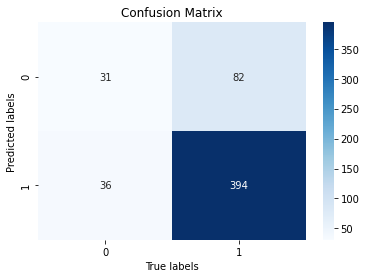

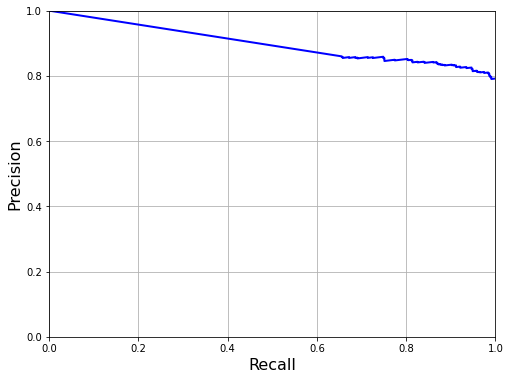

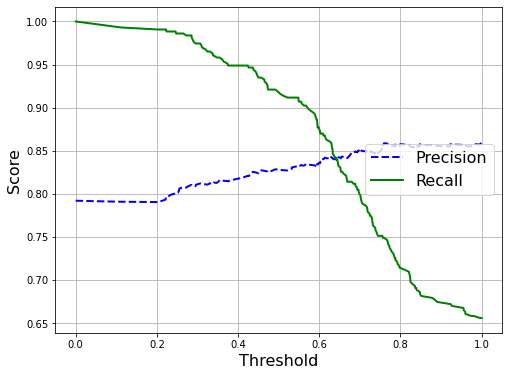

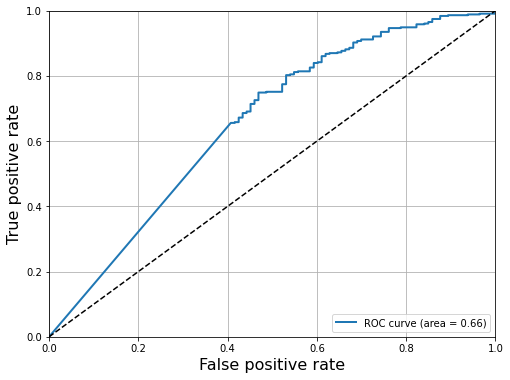

In [157]:
#Calculate prediction values
y_pred_knn = Metrics.predict(KNN)
#Confusion matrix
Metrics.confusion_matrix_plot(y_pred_knn)
#Precision,Recall and F1
print(Metrics.Precision_and_Recall(y_pred_knn))

#Calculate decision values
y_pred_proba_knn = Metrics.predict_prob(KNN)
# score = proba of positive class
#so I take only second column from the output
y_pred_proba_knn = y_pred_proba_knn[:, 1]

#PR
Metrics.PR_plot(y_pred_proba_knn)

#PR vs threshold
Metrics.PR_plot(y_pred_proba_knn, VS = True)

#ROC curve
Metrics.ROC_plot(y_pred_proba_knn)

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.832285  0.923256    0.875413


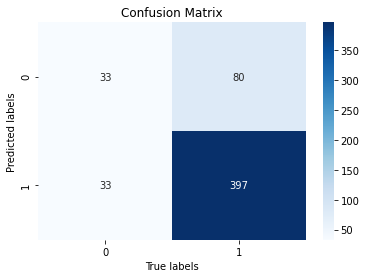

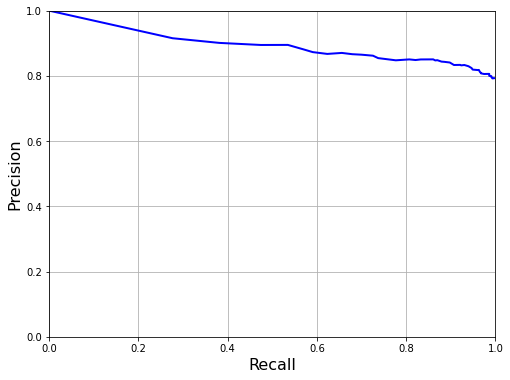

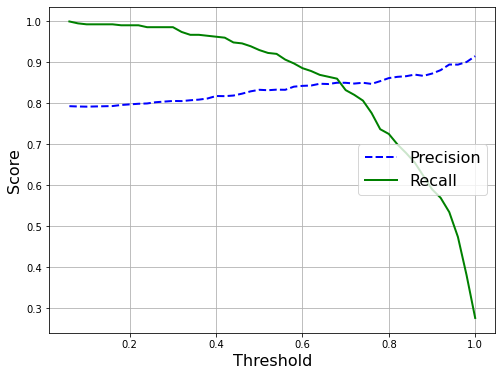

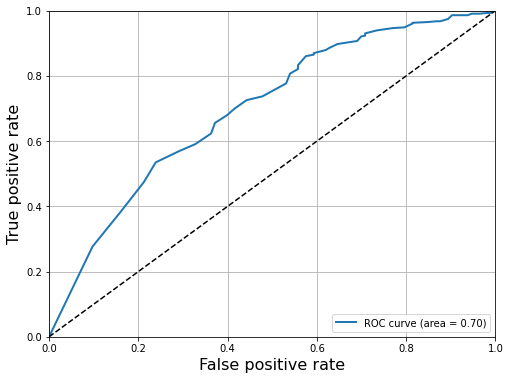

In [158]:
#Calculate prediction values
y_pred_dt = Metrics.predict(tree)
#Confusion matrix
Metrics.confusion_matrix_plot(y_pred_dt)
#Precision,Recall and F1
print(Metrics.Precision_and_Recall(y_pred_dt))

#Calculate decision values
y_pred_proba_dt = Metrics.predict_prob(tree)
# score = proba of positive class
#so I take only second column from the output
y_pred_proba_dt = y_pred_proba_dt[:, 1]

#PR
Metrics.PR_plot(y_pred_proba_dt)

#PR vs threshold
Metrics.PR_plot(y_pred_proba_dt, VS = True)

#ROC curve
Metrics.ROC_plot(y_pred_proba_dt)

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.811508  0.951163    0.875803


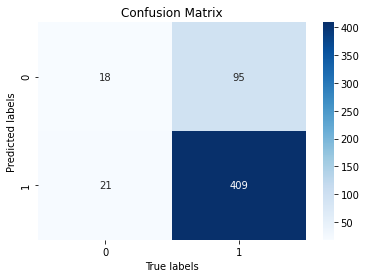

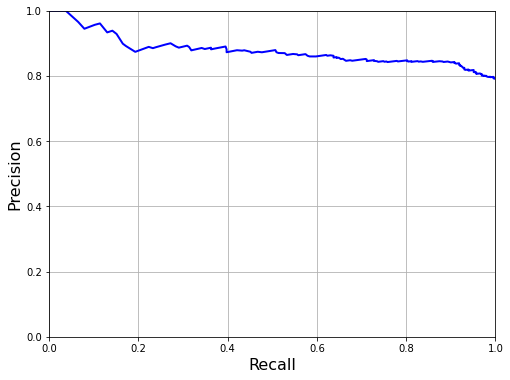

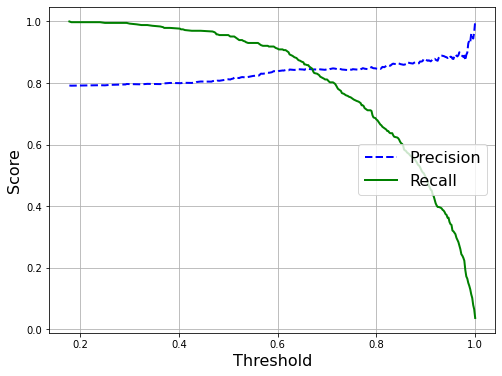

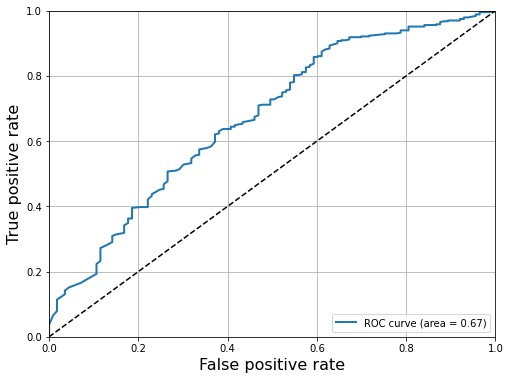

In [159]:
y_pred_rf = Metrics.predict(rf)x
Metrics.confusion_matrix_plot(y_pred_rf)
print(Metrics.Precision_and_Recall(y_pred_rf))
y_pred_proba_rf = Metrics.predict_prob(rf)
y_pred_proba_rf = y_pred_proba_rf[:, 1]

Metrics.PR_plot(y_pred_proba_rf)

Metrics.PR_plot(y_pred_proba_rf, VS = True)

Metrics.ROC_plot(y_pred_proba_rf)


  Precision    Recall    F1 Score
-----------  --------  ----------
   0.838337  0.844186    0.841251


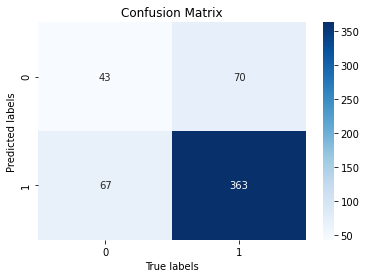

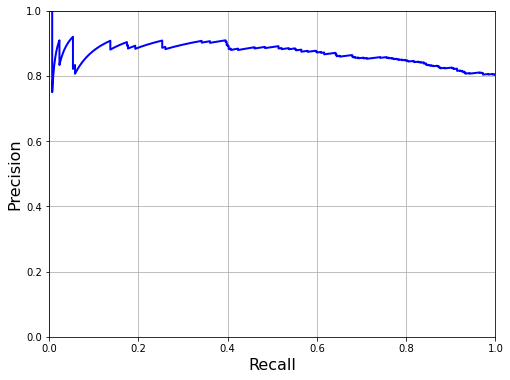

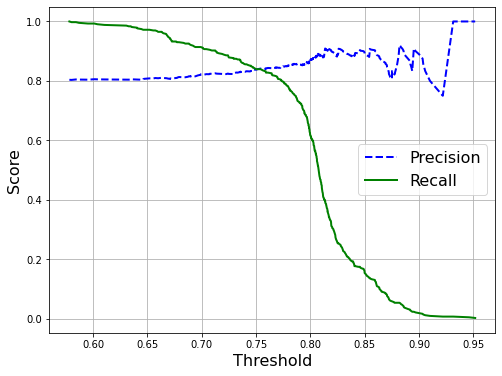

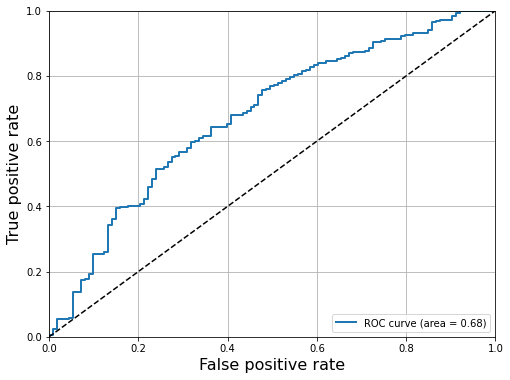

In [160]:

y_pred_svm = Metrics.predict(svm)

Metrics.confusion_matrix_plot(y_pred_svm)

print(Metrics.Precision_and_Recall(y_pred_svm))

y_pred_proba_svm = Metrics.predict_prob(svm)

y_pred_proba_svm = y_pred_proba_svm[:, 1]

#PR
Metrics.PR_plot(y_pred_proba_svm)

#PR vs threshold
Metrics.PR_plot(y_pred_proba_svm, VS = True)

#ROC curve
Metrics.ROC_plot(y_pred_proba_svm)

### Try bagging and adaboost

Bagging with grid search

In [89]:
param_grid = {
    'base_estimator': [svm,KNN,rf, tree],
    'n_estimators': [10,20,30],
    'max_samples': [0.6,0.8,1.0],
}

In [90]:
bag = GridSearchCV(BaggingClassifier(n_jobs = -1),param_grid=param_grid, cv = cv, scoring='roc_auc', return_train_score=False, n_jobs = -1)
bag.fit(X,y)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=1),
             estimator=BaggingClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'base_estimator': [SVC(C=20, class_weight={0: 2, 1: 1},
                                                gamma=2, probability=True,
                                                random_state=42),
                                            KNeighborsClassifier(n_neighbors=3,
                                                                 weights='distance'),
                                            RandomForestClassifier(class_weight={0: 3,
                                                                                 1: 1},
                                                                   criterion='entropy',
                                                                   max_depth=30,
                                                                   n_estimators=500,
                                     

In [91]:
bag.best_score_

0.6894511567786422

In [92]:
bag.best_estimator_

BaggingClassifier(base_estimator=ExtraTreesClassifier(class_weight={0: 4, 1: 1},
                                                      criterion='entropy',
                                                      n_estimators=150,
                                                      n_jobs=-1,
                                                      random_state=42),
                  n_estimators=30, n_jobs=-1)

AdaBoost

In [93]:
ada_param_grid = {
    'base_estimator': [svm,KNN,rf, tree],
    'n_estimators': [10,50,70],
    'learning_rate': [0.5,1.0]
}

In [94]:
ada = GridSearchCV(AdaBoostClassifier(), param_grid = ada_param_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc', return_train_score = False)
ada.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=1),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [SVC(C=20, class_weight={0: 2, 1: 1},
                                                gamma=2, probability=True,
                                                random_state=42),
                                            KNeighborsClassifier(n_neighbors=3,
                                                                 weights='distance'),
                                            RandomForestClassifier(class_weight={0: 3,
                                                                                 1: 1},
                                                                   criterion='entropy',
                                                                   max_depth=30,
                                                                   n_estimators=500,
                                             

In [95]:
ada.best_score_

0.7097869663808876

In [96]:
ada.best_estimator_

AdaBoostClassifier(base_estimator=ExtraTreesClassifier(class_weight={0: 4,
                                                                     1: 1},
                                                       criterion='entropy',
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42),
                   n_estimators=10)

Try Voting classifier

In [40]:
voting = VotingClassifier(estimators=[('tree', tree), ('rf', rf), ('knn',KNN),('svm',svm)], voting='soft')
voting.fit(X,y)
cross_val_score(voting,X,y,cv = cv, scoring = 'roc_auc').mean()

0.6947212787192912

## Oversampling with SMOTE

In [232]:
#funtion to find best k,sampling strategy and hyperparams
def find_best_params(models_params,
                    X,
                    y, 
                    k_values = [1,3,5,7], 
                    sampling_strategy = [0.6,0.8,1]):
    df = pd.DataFrame(columns=['k', 's', 'best_score', 'best_params'])
    for model_name, mp in models_params.items():
        print('--------------------------')
        print('\nProcessing ',model_name,'\n')
        scores = []
        i = 1
        for k in k_values:
            print('Processing K...',i,'/',len(k_values))
            j=1
            for s in sampling_strategy:
                print('Processing sampling strategy ...',j,'/',len(sampling_strategy))
                # define pipeline
                imba_pipeline = make_pipeline(SMOTE(sampling_strategy=s,random_state=42, k_neighbors=k),
                                                mp['model'])
                
                grid_imba = GridSearchCV(imba_pipeline, param_grid = mp['params'], cv = cv, scoring = 'roc_auc', return_train_score = False, n_jobs = -1)
                grid_imba.fit(X, y)
                scores.append({
                    'k': k,
                    's': s,
                    'best_score': grid_imba.best_score_,
                    'best_params': grid_imba.best_params_
                })
                j+=1
            i += 1 
                    
        tmp = pd.DataFrame(scores).sort_values(by = 'best_score', ascending = False).head(1)
        df = df.append(tmp, ignore_index = True)
    return(df)


In [47]:
#hyper params for models
model_params = {
    'svm':{ 
        'model': SVC(kernel = 'rbf', probability = True, random_state = 42),
        'params': {
            'svc__C': [1,10,20,50,100],
            'svc__class_weight': [{1:0.4,0:0.6},{1:0.45,0:0.55},{1:1,0:1}],
            'svc__gamma': [0.1,0.5,1,2,3,4,5,'auto','scale']

        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state = 42),
        'params' : {
            'decisiontreeclassifier__criterion' : ['gini', 'entropy'],
            'decisiontreeclassifier__splitter' : ['best', 'random'],
            'decisiontreeclassifier__max_depth': [3,4,5,10,30,None],
            'decisiontreeclassifier__class_weight' : [{1:0.4,0:0.6},{1:0.45,0:0.55},{1:1,0:1}]
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(n_jobs=-1,random_state = 42),
        'params' : {
            'randomforestclassifier__n_estimators': [50,100,200,500],
            'randomforestclassifier__criterion' : ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [3,4,5,10,30,None],
            'randomforestclassifier__class_weight' : [{1:0.4,0:0.6},{1:0.45,0:0.55},{1:1,0:1}]
        }
    },
    'KNN':{
        'model': KNeighborsClassifier(n_jobs=-1),
        'params' : {
            'kneighborsclassifier__n_neighbors': [1,2,3,5,7],
            'kneighborsclassifier__weights': ['uniform', 'distance'],
            'kneighborsclassifier__p': [1,2]
        }
    },
    'xgboost':{
        'model': xgb.XGBClassifier(random_state = 42),
        'params': {
            'xgbclassifier__max_depth': [6,10],
            'xgbclassifier__learning_rate':[0.01,0.15],
            'xgbclassifier__gamma':[0.0,0.1]
        }
    }
}

In [61]:
#hyper params for ExtraTreesClassifier
#I do it separately because I later added ExtraTreesClassifier
tree_params = {
    'extratree':{
        'model': ExtraTreesClassifier(random_state=42, n_jobs = -1),
        'params': {
            'extratreesclassifier__criterion' : ['gini', 'entropy'],
            'extratreesclassifier__n_estimators': [20,50,100,150],
            'extratreesclassifier__max_depth': [3,4,7, None],
            'extratreesclassifier__class_weight' : [{1:1,0:1},{1:1,0:1.5},{1:1,0:2}]
        }
    }
}

In [62]:
tree_smote = find_best_params(tree_params,X,y, k_values=[1,3,6,7,8,9],sampling_strategy=[0.5,0.55,0.6,0.65,0.7] )

--------------------------

Processing  extratree 

Processing K... 1 / 6
Processing sampling strategy ... 1 / 5
Processing sampling strategy ... 2 / 5
Processing sampling strategy ... 3 / 5
Processing sampling strategy ... 4 / 5
Processing sampling strategy ... 5 / 5
Processing K... 2 / 6
Processing sampling strategy ... 1 / 5
Processing sampling strategy ... 2 / 5
Processing sampling strategy ... 3 / 5
Processing sampling strategy ... 4 / 5
Processing sampling strategy ... 5 / 5
Processing K... 3 / 6
Processing sampling strategy ... 1 / 5
Processing sampling strategy ... 2 / 5
Processing sampling strategy ... 3 / 5
Processing sampling strategy ... 4 / 5
Processing sampling strategy ... 5 / 5
Processing K... 4 / 6
Processing sampling strategy ... 1 / 5
Processing sampling strategy ... 2 / 5
Processing sampling strategy ... 3 / 5
Processing sampling strategy ... 4 / 5
Processing sampling strategy ... 5 / 5
Processing K... 5 / 6
Processing sampling strategy ... 1 / 5
Processing sampling

In [72]:
tree_smote

k    s  best_score                                        best_params
0  6  0.6    0.715482  {'extratreesclassifier__class_weight': {1: 1, ...

In [48]:
Best_models = find_best_params(model_params,X,y)

--------------------------

Processing  svm 

Processing K... 1 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
Processing K... 2 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
Processing K... 3 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
Processing K... 4 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
--------------------------

Processing  decision_tree 

Processing K... 1 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
Processing K... 2 / 4
Processing sampling strategy ... 1 / 3
Processing sampling strategy ... 2 / 3
Processing sampling strategy ... 3 / 3
Processing K... 3 / 4
Processing sampling strategy ... 1 / 3
Pro

In [49]:
Best_models

k    s  best_score                                        best_params
0  7  0.6    0.663292  {'svc__C': 10, 'svc__class_weight': {1: 1, 0: ...
1  1  0.8    0.635681  {'decisiontreeclassifier__class_weight': {1: 1...
2  7  0.6    0.679373  {'randomforestclassifier__class_weight': {1: 1...
3  7  0.8    0.676708  {'kneighborsclassifier__n_neighbors': 7, 'knei...
4  5  1.0    0.664009  {'xgbclassifier__gamma': 0.0, 'xgbclassifier__...

### Build models with best hyperparams, k, and sampling strategy

In [228]:
xgb_pipeline = make_pipeline(SMOTE(sampling_strategy=1,random_state=42, k_neighbors=5),
                              xgb.XGBClassifier(gamma = 0.0, learning_rate = 0.15, max_depth = 10))
rf_pipeline = make_pipeline(SMOTE(sampling_strategy=0.6,random_state=42,k_neighbors=7),
                            RandomForestClassifier(criterion = 'entropy', class_weight = {1: 1, 0:1}, max_depth = 30, n_estimators = 500))

svm_pipeline = make_pipeline(SMOTE(sampling_strategy=0.6, random_state=42, k_neighbors=7),
                                SVC(C = 10, class_weight = {1:1,0:1}, gamma = 3))

knn_pipepline = make_pipeline(SMOTE(sampling_strategy = 0.8, k_neighbors = 7),
                                KNeighborsClassifier(n_neighbors= 7, p =2 , weights = 'distance'))

tree_pipeline = make_pipeline(SMOTE(sampling_strategy= 0.6, k_neighbors=7, random_state=42),
                                ExtraTreesClassifier(class_weight={1: 1, 0: 1.5},criterion='gini',n_estimators=50))

### Evaluate those models

In [229]:
xgb_pipeline_roc = cross_val_score(xgb_pipeline, X,y,cv = cv, scoring='roc_auc')
rf_pipeline_roc = cross_val_score(rf_pipeline, X,y,cv = cv, scoring='roc_auc')
svm_pipeline_roc = cross_val_score(svm_pipeline, X,y,cv = cv, scoring='roc_auc')
knn_pipepline_roc = cross_val_score(knn_pipepline, X,y,cv = cv, scoring='roc_auc')
tree_pipeline_roc = cross_val_score(tree_pipeline, X,y,cv = cv, scoring='roc_auc')

[22:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

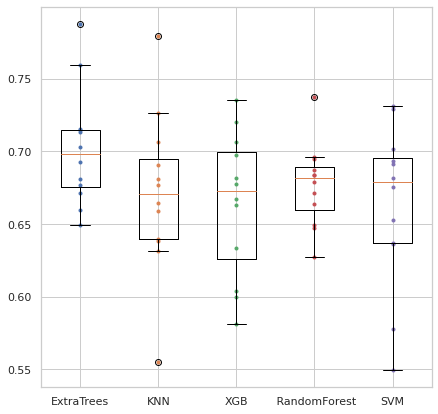

In [231]:
plt.figure(figsize=(7,7))
plt.plot([1]*12, tree_pipeline_roc, ".")
plt.plot([2]*12, knn_pipepline_roc, ".")
plt.plot([3]*12, xgb_pipeline_roc, ".")
plt.plot([4]*12, rf_pipeline_roc, ".")
plt.plot([5]*12, svm_pipeline_roc, ".")
plt.boxplot([tree_pipeline_roc, knn_pipepline_roc,xgb_pipeline_roc,rf_pipeline_roc ,svm_pipeline_roc ], labels=("ExtraTrees","KNN", 'XGB',' RandomForest','SVM'))
plt.savefig('./plots/roc_auc_SMOTE.png')
plt.show()

### Try Bagging with grid search again 

In [119]:
param_grid = {
    'base_estimator': [xgb_pipeline,rf_pipeline,svm_pipeline, knn_pipepline,tree_pipeline],
    'n_estimators': [10,20,30],
    'max_samples': [0.6,0.8,1.0],
}

In [120]:
bag_smote = GridSearchCV(BaggingClassifier(n_jobs = -1),param_grid=param_grid, cv = cv, scoring='roc_auc', return_train_score=False, n_jobs = -1)
bag_smote.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=1),
             estimator=BaggingClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'base_estimator': [Pipeline(steps=[('smote',
                                                             SMOTE(random_state=42,
                                                                   sampling_strategy=1)),
                                                            ('xgbclassifier',
                                                             XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=N...
                                                         

In [121]:
bag_smote.best_score_

0.6849127291760094

In [122]:
bag_smote.best_estimator_

BaggingClassifier(base_estimator=Pipeline(steps=[('smote',
                                                  SMOTE(k_neighbors=7,
                                                        random_state=42,
                                                        sampling_strategy=0.6)),
                                                 ('extratreesclassifier',
                                                  ExtraTreesClassifier(class_weight={0: 1.5,
                                                                                     1: 1},
                                                                       n_estimators=50))]),
                  n_estimators=20, n_jobs=-1)

#### Try Stacking this time with best algorithms

In [96]:
m = StackingClassifier(
    estimators=[('tree',tree),
        ('tree_pipe',tree_pipeline),
        ('knn', KNN),
        ('knn_pipe', knn_pipepline),
        ('rf', rf),
        ('rf_pipe', rf_pipeline)],
    final_estimator=LogisticRegression()
)

In [97]:
m.fit(X,y)


StackingClassifier(estimators=[('tree',
                                ExtraTreesClassifier(class_weight={0: 3, 1: 1},
                                                     n_estimators=50, n_jobs=-1,
                                                     random_state=42)),
                               ('tree_pipe',
                                Pipeline(steps=[('smote',
                                                 SMOTE(k_neighbors=6,
                                                       random_state=42,
                                                       sampling_strategy=0.6)),
                                                ('extratreesclassifier',
                                                 ExtraTreesClassifier(class_weight={0: 1,
                                                                                    1: 1}))]))],
                   final_estimator=LogisticRegression())

In [94]:
cross_val_score(m,X,y,cv=cv, scoring='roc_auc').mean()

0.8010984023238926

# Save best model

In [ ]:
filename = 'tree.pkl'
joblib.dump(tree, filename)